# Result analysis

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from experiment import Experiment
from utils import PlaceFields, get_flanks, get_loc_batch, print_stats, eval_position
from agent import Agent
from tqdm import tqdm

In [2]:
exp = Experiment.load_experiment('data', 'hidden50')

In [4]:
exp.compile_grid_cells(1)
exp.load_pfs()

### Fitting losses

Position loss: 0.340


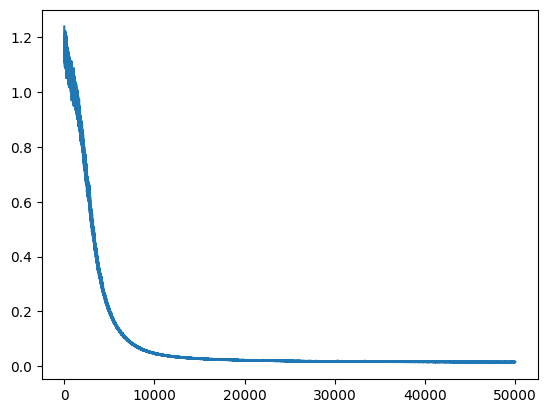

In [5]:
print(f"Position loss: {eval_position(exp.agent, exp.coords, exp.grid_cells):.03f}")
plt.plot(exp.pos_losses)
plt.show()

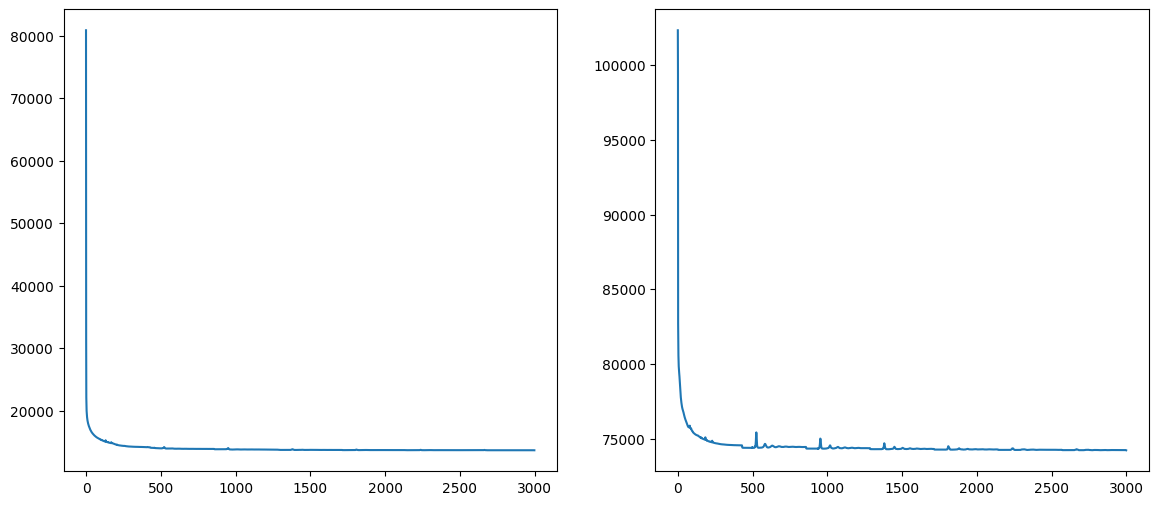

In [6]:
_, axs = plt.subplots(1, len(exp.pfs_losses), figsize=(14, 6))
for ax, loss in zip(axs, exp.pfs_losses.values()):
    ax.plot(loss)
plt.show()

### Network weight analysis

In [7]:
net = exp.agent.actor
net.clamp_weights()

print("Bias stats:")
print_stats(net.b1)
print("\nWeight stats:")
print_stats(net.w1)
print("\nAggregated weight stats:")
print_stats(net.w1.sum(1))

Bias stats:
min   |max  |mean |std  |shape
-0.436|0.918|0.196|0.519|torch.Size([50])

Weight stats:
min   |max  |mean |std  |shape
0.000|4.228|0.206|0.211|torch.Size([50, 1000])

Aggregated weight stats:
min   |max  |mean |std  |shape
194.332|222.947|206.295|11.974|torch.Size([50])


In [8]:
hidden = exp.agent_kwargs['actor_hidden']
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:].numpy() + [[0], [hidden]]
print(net.lin2.weight[2:].detach().cpu().flatten()[idx.flatten()])

tensor([ 5.0702,  5.0789, -5.1135, -5.2200, -5.5135, -4.9965,  5.1441, -5.2399,
         5.3185,  5.4446])


### Place field analysis

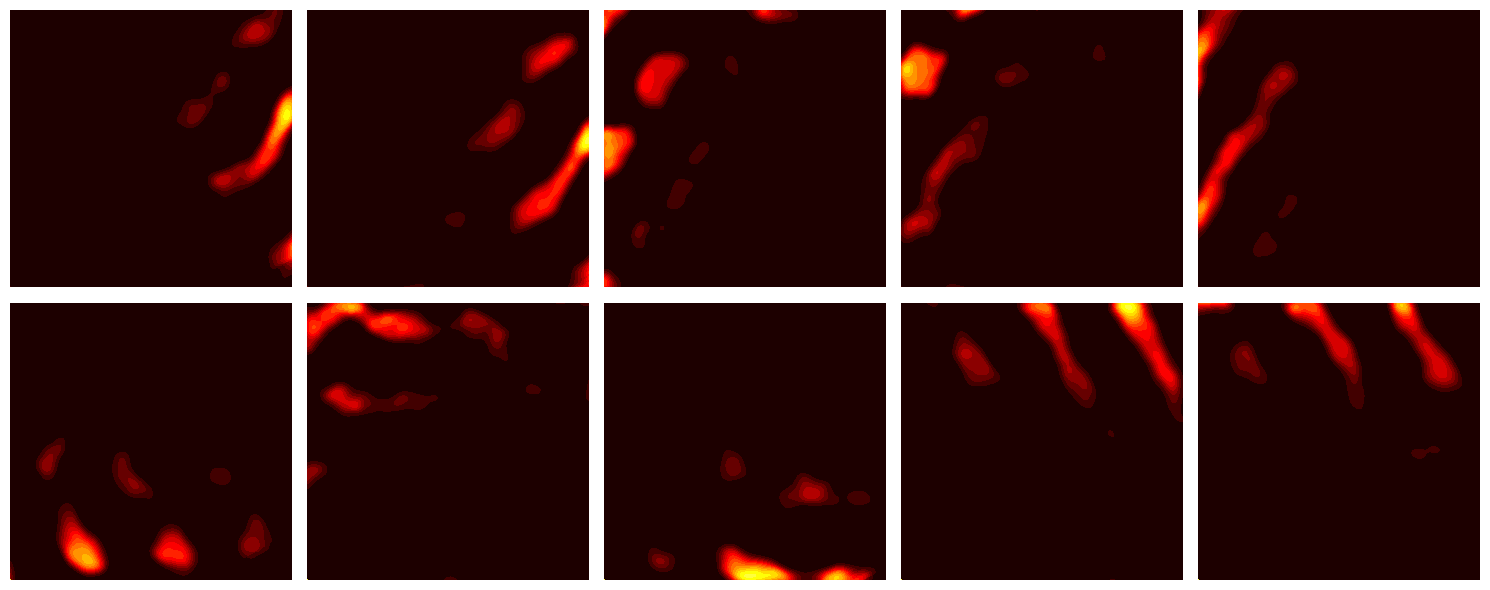

In [9]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

hidden = net.lin1(exp.grid_cells).permute((-1, 0, 1)).detach().cpu().numpy()

# Small hack to ensure the scale of every plot is the same
hidden[:,0,0] = hidden.max()
hidden[:,0,1] = hidden.min()

idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:]
for img, ax in zip(hidden[idx.flatten()], axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()

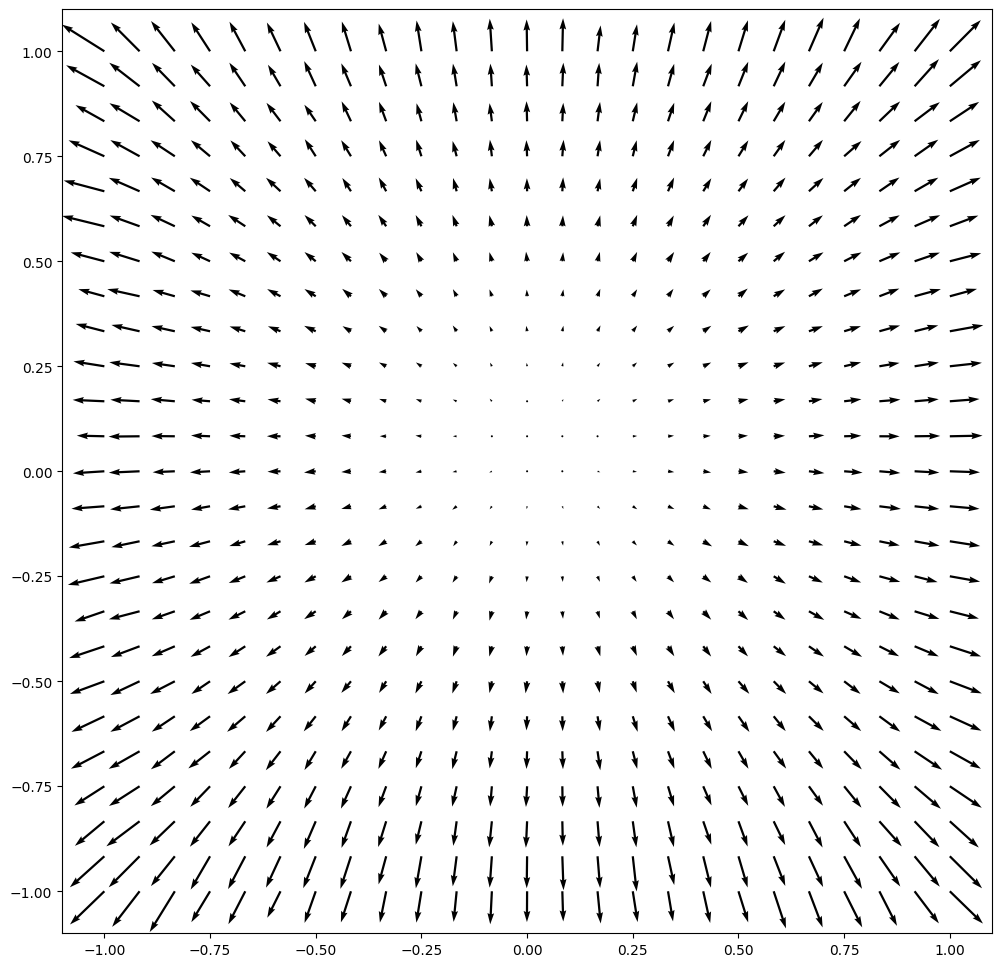

In [10]:
xy = np.linspace(-1, 1, 25)
X, Y = np.meshgrid(xy, xy)

plt.figure(figsize=(12, 12))
plt.quiver(X, Y, *net.lin2(net.lin1(exp.grid_cells))[::16,::16,2:].permute(-1, 0, 1).detach().cpu())
plt.show()

Layer 2 weights from most active hidden units
min   |max  |mean |std  |shape
-5.513|5.445|0.046|3.666|torch.Size([2, 30])

Layer 2 weights from least active hidden units
min   |max  |mean |std  |shape
-3.447|3.270|0.001|0.899|torch.Size([2, 20])


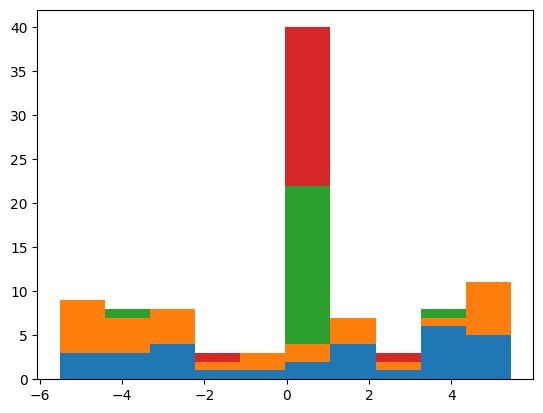

In [12]:
used = hidden.mean((1, 2)) > hidden.mean()# + hidden.mean((1, 2)).std() / 20

print("Layer 2 weights from most active hidden units")
print_stats(net.lin2.weight[2:, used])
print("\nLayer 2 weights from least active hidden units")
print_stats(net.lin2.weight[2:, ~used])

plt.hist([*net.lin2.weight[2:, used].detach().cpu(),
          *net.lin2.weight[2:, ~used].detach().cpu()],
         histtype='barstacked')
plt.show()

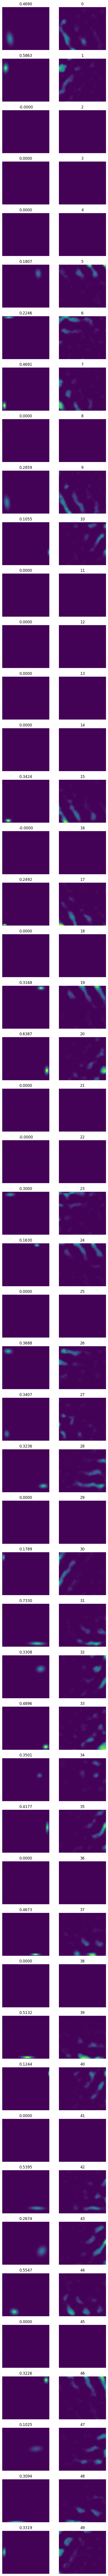

In [13]:
N = exp.pfs.means.shape[0]
preds = exp.pfs.predict().cpu().detach().numpy()
preds[:,0,0] = hidden.max()
hidden[:,0,0] = hidden.max()
explained = 1 - torch.pow(exp.pfs.predict() - exp.pfs.targets, 2).sum((1, 2)) / torch.pow(exp.pfs.targets, 2).sum((1, 2))

for i, ((ax1, ax2), pred, real, expl) in enumerate(zip(plt.subplots(N, 2, figsize=(6, 3*N))[1],
                                                       preds, hidden[:N], explained.cpu().detach())):
    ax1.contourf(pred, levels=100)
    ax1.axis('off')
    ax1.set_title(f"{expl.item():.04f}")
    ax2.contourf(real, levels=100)
    ax2.axis('off')
    ax2.set_title(i)
plt.show()

In [14]:
exp.compile_grid_cells(2)
exp.load_pfs()

In [15]:
hidden = net.lin1(exp.grid_cells).permute((-1, 0, 1)).detach().cpu().numpy()
hidden[:,0,0] = hidden.max()
hidden[:,0,1] = hidden.min()

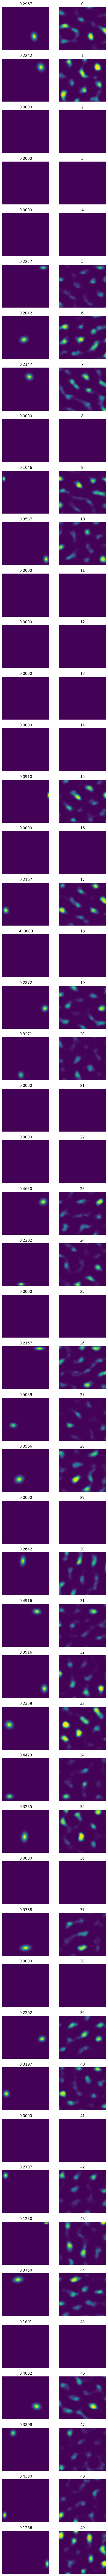

In [16]:
N = exp.pfs.means.shape[0]
preds = exp.pfs.predict().cpu().detach().numpy()
preds[:,0,0] = hidden.max()
hidden[:,0,0] = hidden.max()
explained = 1 - torch.pow(exp.pfs.predict() - exp.pfs.targets, 2).sum((1, 2)) / torch.pow(exp.pfs.targets, 2).sum((1, 2))

for i, ((ax1, ax2), pred, real, expl) in enumerate(zip(plt.subplots(N, 2, figsize=(6, 3*N))[1],
                                                       preds, hidden[:N], explained.cpu().detach())):
    ax1.contourf(pred, levels=100)
    ax1.axis('off')
    ax1.set_title(f"{expl.item():.04f}")
    ax2.contourf(real, levels=100)
    ax2.axis('off')
    ax2.set_title(i)
plt.show()